# Рекуррентные нейронные сети

В этой лабораторной работе вы будете использовать рекуррентные нейронные сети.

In [ ]:
# Установка библиотеки opendatasets
! pip install opendatasets --upgrade

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import os
import time
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Embedding, Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2

#### Теория

##### RNN

Рекуррентные нейронные сети (RNN) — вид нейронных сетей, где связи между элементами образуют направленную последовательность. Благодаря этому появляется возможность обрабатывать серии событий во времени или последовательные пространственные цепочки. В отличие от многослойных перцептронов, рекуррентные сети могут использовать свою внутреннюю память для обработки последовательностей произвольной длины.

RNN хорошо подходят для моделирования последовательных данных, таких как временные ряды или естественный язык.

Схематично, слой RNN использует цикл for для итерации по упорядоченной по времени последовательности, храня при этом во внутреннем состоянии, закодированную информацию о шагах, которые он уже видел.

RNN и ее развернутое представление представлено на картинке (здесь цикл разворачивается, представляя сеть как копию одинаковых блоков  A).

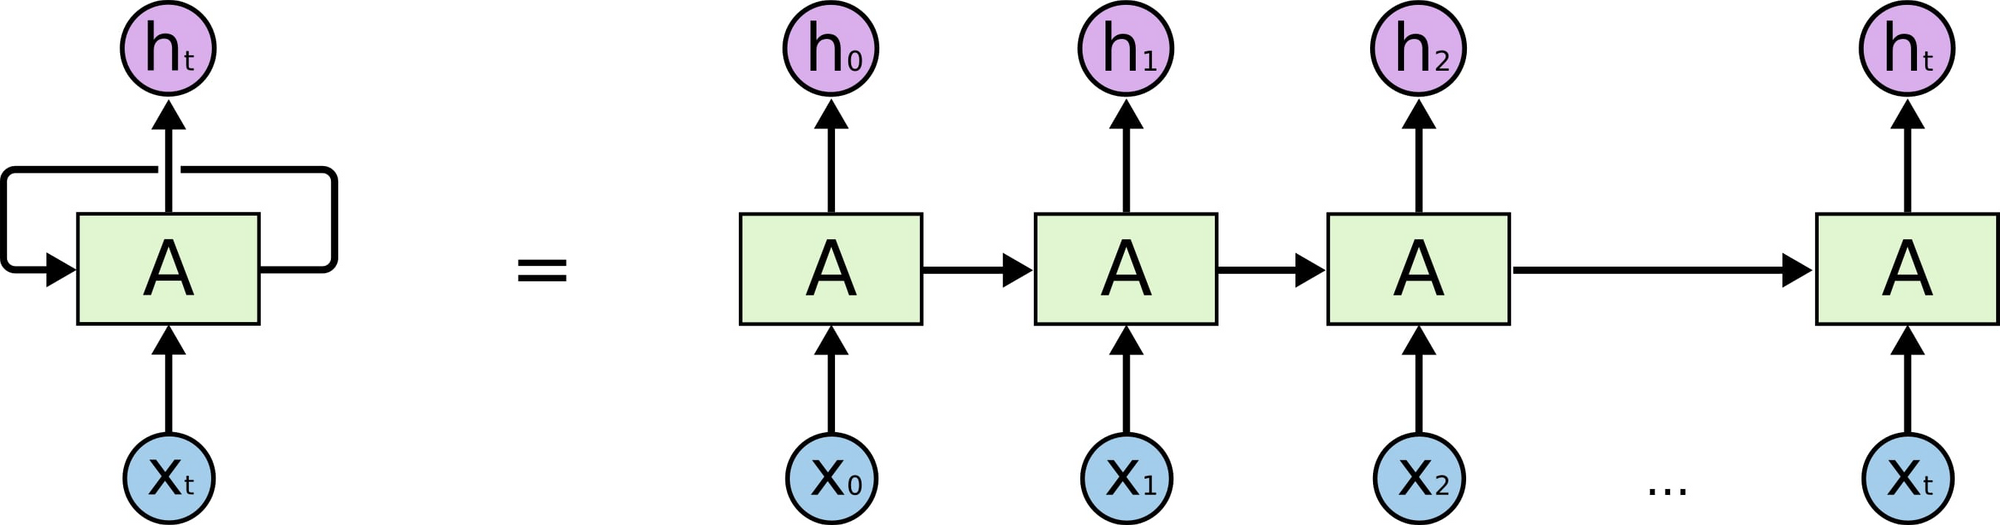

Простыми словами, RNN знает не только текущий вход, но и то, что было до него, т.к. передаётся информация с предыдущих слоёв.

Информация накапливается в векторе $h_t$.

Типичная классическая рекуррентная нейронная сеть использует только три набора параметров веса для выполнения требуемых подсчетов:

$W_{xh}$ используется для всех связок $x_t → h_t$

$W_{hh}$ используется для всех связок $h_{t-1} → h_t$

$W_{hy}$ используется для всех связок $h_t → y_t $

Могут быть также добавлены смещения:

$b_h$ добавляется при подсчете $h_t$

$b_y$ добавляется при подсчете $y_t$

$$ h_t = \tanh (W_{xh}x_t + W_{hh}h_{t-1}+b_h)$$

$$ y = W_{hy}h_t+b_y$$

##### LSTM

Рекуррентные нейронные сети добавляют память к искуственным нейронным сетям, но реализуемая память получается короткой — на каждом шаге обучения информация в памяти смешивается с новой и через несколько итераций полностью перезаписывается.

**LSTM-сети** разработаны специально, чтобы избежать проблемы долговременной зависимости, запоминая значения как на короткие, так и на длинные промежутки времени.

Архитектура сети представлена на картинке.

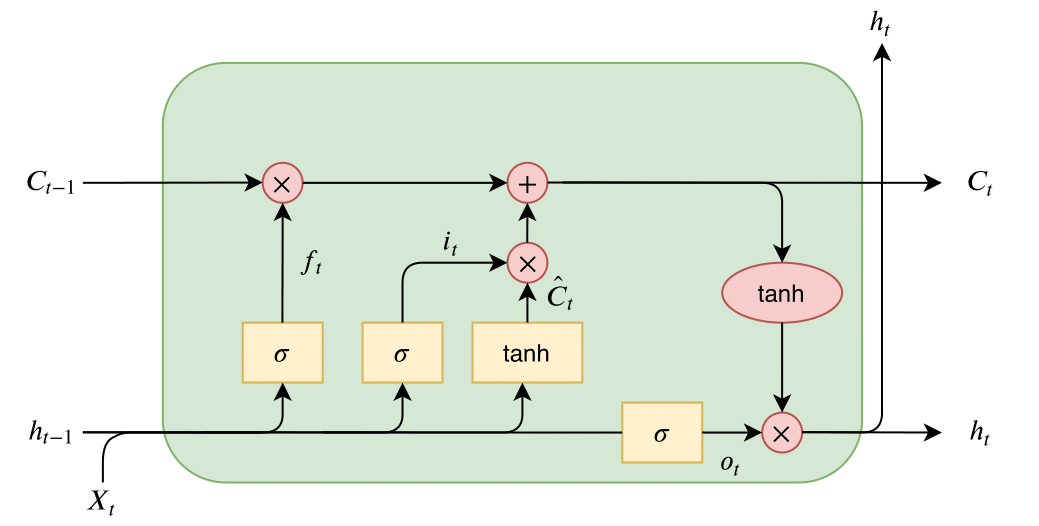

Вверху показан $C_t$, который представляет долгосрочную память. У неё есть механизмы, решающие, какую информацию сохранить, удалить или обновить.

**Шаги работы LSTM:**

1. **Фильтр забывания ($f_t$):**  
   На этом шаге определяются те части предыдущей долгосрочной памяти ($C_{t-1}$), которые нужно сохранить или забыть.  
   На вход поступают:
   - **Предыдущее скрытое состояние ($h_{t-1}$):** содержит информацию из предыдущего шага, отражающую контекст.
   - **Текущие входные данные ($x_t$):** отражают новую информацию, поступающую на текущем шаге.

   Эти два элемента объединяются, и результат проходит через сигмоидальную функцию активации:  
  $
   f_t = \sigma(W_f[h_{t-1}, x_t] + b_f)
  $
   Сигмоида выдаёт значения в диапазоне $[0, 1]$:  
   - Значения ближе к 0 означают, что информация будет забыта.  
   - Значения ближе к 1 — что информация будет сохранена.

   **Почему нужен $x_t$?**  
   Входные данные ($x_t$) позволяют учитывать текущий контекст и обновлять память на основе новой информации, а не только прошлого состояния.

2. **Добавление новой информации ($i_t$ и $\tilde{C}_t$):**  
   Этот шаг отвечает за обновление долгосрочной памяти:
   - **Решение, что добавить ($i_t$):**  
     Как и в случае с $f_t$, входные данные ($x_t$) и предыдущее скрытое состояние ($h_{t-1}$) проходят через сигмоидальную функцию:  
     $
     i_t = \sigma(W_i[h_{t-1}, x_t] + b_i)
     $
     Результат ($i_t$) определяет, какая часть новой информации будет добавлена в память:  
     - Значения ближе к 0 означают, что новая информация не будет учитываться.  
     - Значения ближе к 1 — что она будет добавлена.

   - **Создание новой информации ($\tilde{C}_t$):**  
     Входные данные ($x_t$) и предыдущее скрытое состояние ($h_{t-1}$) также проходят через гиперболический тангенс ($\tanh$):  
     $ \tilde{C}_t = $

     $ \tanh(W_c[h_{t-1}, x_t] + b_c)$
     
     Это создаёт "кандидатов" для добавления в память. Проще говоря, $\tilde{C}_t$ — это потенциально важная информация, обработанная с учётом текущего контекста.

   Обновление памяти производится следующим образом:  
   $
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $
   Здесь:  
   - $f_t \cdot C_{t-1}$ отвечает за сохранение важной информации из прошлой памяти.  
   - $i_t \cdot \tilde{C}_t$ добавляет новую обработанную информацию.

3. **Определение выхода ($o_t$):**  
   На этом этапе решается, какая информация будет выведена как скрытое состояние ($h_t$).
   - Сигмоида определяет, какие элементы памяти ($C_t$) нужно вывести:  
     $
     o_t = \sigma(W_o[h_{t-1}, x_t] + b_o)
     $
   - Гиперболический тангенс ($\tanh(C_t)$) масштабирует обновлённую память, чтобы выделить наиболее важную информацию.

   Итоговый вывод:  
   $
   h_t = o_t \cdot \tanh(C_t)
   $

**Разница между нейронами полносвязной сети (Dense) и нейронами LSTM**

Dense:
- Каждый нейрон в плотном слое получает входные данные от всех нейронов предыдущего слоя.
- В полносвязных слоях не учитывается временная или последовательная природа данных — они обрабатывают входные данные независимо, как единое целое.
- Каждый модуль Dense использует весовую матрицу, смещение и функцию активации для вычисления своих выходных данных.

LSTM:
- Каждый нейрон LSTM является более сложным, поскольку он обрабатывает последовательные данные, сохраняя внутреннюю "память" прошлой информации.
- Модуль LSTM имеет такие компоненты, как:
-- Forget Gate: Определяет, какую существующую информацию следует удалить.
-- Input Gate: решает, какую новую информацию сохранить.
-- Output Gate: определяет, что нейрон выдает на данном шаге.
-Каждый нейрон выдает выходные данные на основе текущего входного сигнала и своей собственной памяти (состояния).

Таким образом:
- Как Dense, так и LSTM-блоки являются "нейронами" в нейронных сетях.
- Полносвязные сети проще и обрабатывают статические данные.
- LSTM-сети специализированы для обработки последовательностей и включают дополнительные механизмы для обработки временных зависимостей.

Дополнительно: https://habr.com/ru/companies/wunderfund/articles/331310/

## Задача классификации ЭКГ

https://www.kaggle.com/datasets/shayanfazeli/heartbeat - набор данных ЭКГ. Используйте мультиклассовый датасет.

Для начала - задача классификации ЭКГ. Импортируйте датасет, подготовьте выборку, постройте и обучите модель, протестируйте её и в виде гистограмм проиллюстрируйте, в каких классах чаще ошибается нейронная сеть. Также для каждого класса постройте отдельную гистограмму, содержащую ложно классифицированные данные по разным классам.

### Загрузка и предобработка данных

In [ ]:
# Загрузка датасета
od.download("https://www.kaggle.com/datasets/shayanfazeli/heartbeat")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: intergalactik
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat


100%|██████████| 98.8M/98.8M [00:00<00:00, 120MB/s]


In [ ]:
# Объявление путей к файлам датасета
data_path = "./heartbeat/mitbih_train.csv"
test_data_path = "./heartbeat/mitbih_test.csv"

# Чтение файлов датасета в pd датафреймы
train_data = pd.read_csv(data_path, header=None)
test_data = pd.read_csv(test_data_path, header=None)

# Отображение первых нескольких строк датасета
print("Часть данных обучающей выборки:")
print(train_data.head())

# Вывод размерности датасетов
print(f"Размерность обучающей выборки: {train_data.shape}")
print(f"Размерность тестовой выборки: {test_data.shape}")

Training data sample:
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0

**Информация о датасете с Kaggle**

Все строки обрезаются, уменьшаются в размерах и, при необходимости, дополняются нулями до фиксированного размера 188.

Первые 187 столбцов представляют данные ЭКГ-сигнала.
Последний столбец представляет собой метку класса.

In [ ]:
# Убеждаемся, что последний столбец отражает метку класса - выводим уникальные значения, которые он принимает
unique_values = train_data.iloc[:, -1].unique()
unique_values

array([0., 1., 2., 3., 4.])

In [ ]:
# Разделение признаков и меток классов для обучающей выборки
X_train = train_data.iloc[:, :-1].values  # Признаки (первые 187 столбцов)
y_train = train_data.iloc[:, -1].values   # Метки классов (последний столбец)
# .values преобразует датафрейм в массив NumPy
# Массивы NumPy быстрее и эффективнее для вычислений (например, для передачи данных в нейросеть). Без .values возвращается pd dataframe

# Разделение признаков и меток классов для тестовой выборки
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# One-hot кодирование отклика (меток классов)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Вывод размерностей данных
print(f"Размерность массива признаков обучающей выборки: {X_train.shape}")
print(f"Размерность массива меток классов обучающей выборки: {y_train.shape}")
print(f"Размерность массива признаков тестовой выборки: {X_test.shape}")
print(f"Размерность массива меток классов тестовой выборки: {y_test.shape}")

Training features shape: (87554, 187)
Training labels shape: (87554, 5)
Test features shape: (21892, 187)
Test labels shape: (21892, 5)


In [ ]:
# Изменение размерности входных данных для RNN (LSTM ожидает 3D-массив: (записи, временные шаги, признаки)(samples, timesteps, features)):
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
"""
Пояснение про изменение размерности

LSTM (и другие RNNs в целом) ожидают на входе 3D-массив (samples, timesteps, features):
- samples: количество последовательностей (записей) в наборе данных (например, количество строк в X_train).
- timesteps: количество временных шагов (или длина последовательности). Для данных ЭКГ это значение равно 187, поскольку каждая выборка содержит 187 значений.
- features: Количество признаков на каждом временном шаге. Для одномерных последовательностей (таких как этот набор данных ЭКГ) на каждый временной шаг приходится всего 1 признак.

Изменение размерности преобразует данные из этого формата:
[[t1, t2, t3, ..., t187],  # First sample
 [t1, t2, t3, ..., t187],  # Second sample
 ...]
(Shape: (samples, timesteps))

В этот:
[[[t1], [t2], [t3], ..., [t187]],  # First sample
 [[t1], [t2], [t3], ..., [t187]],  # Second sample
 ...]
(Shape: (samples, timesteps, features))

Здесь каждое значение t становится своим собственным временным шагом [t], добавляя новое измерение "признаки". В данном случае количество признаков в шаге = 1.

Это необходимо, т.к. LSTM требуют, чтобы данные имели третье измерение (признаки) для правильной обработки последовательностей.

Если не изменять размерность, то:
- Keras интерпретирует 2D-данные как (samples, features), а не как (samples, timesteps, features).
- LSTM обрабатывает каждую последовательность из 187 временных шагов как один шаг со 187 признаками.
Это не идеально, поскольку при этом теряется последовательный характер данных — ЭКГ-сигнал обрабатывался как единый плоский вектор, а не как последовательность.

"""

### Построение, обучение и валидация модели

In [ ]:
# Создание модели
RNN_model = Sequential()
# Слой LSTM с 128 нейронами, функция активации - тангенс гиперболический - дефолтный для LSTM
# input_shape - каждая последовательность содержит 187 временных шагов, и 1 признак в каждом шаге
# return_sequences=False - накопленная информация о самих последовательностях не возвращается
# Поскольку мы работаем с классификацией, нам нужны только окончательные выходные данные LSTM
RNN_model.add(LSTM(128, input_shape=(X_train.shape[1], 1), activation='tanh', return_sequences=False))
# Выходной слой с 5 нейронами и функцией softmax
RNN_model.add(Dense(5, activation='softmax'))

# Компиляция модели
RNN_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Информация о модели
RNN_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,205 (262.52 KB)

 Trainable params: 67,205 (262.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Обучение модели
RNN_history = RNN_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping])

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(RNN_history.history['accuracy']):.4f}")

Epoch 1/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 571s 414ms/step - accuracy: 0.8246 - loss: 0.6967 - val_accuracy: 0.8276 - val_loss: 0.6548
Epoch 2/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 615s 409ms/step - accuracy: 0.8274 - loss: 0.6544 - val_accuracy: 0.8287 - val_loss: 0.6465
Epoch 3/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 561s 410ms/step - accuracy: 0.8284 - loss: 0.6501 - val_accuracy: 0.8276 - val_loss: 0.6502
Epoch 4/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 532s 388ms/step - accuracy: 0.8276 - loss: 0.6459 - val_accuracy: 0.8278 - val_loss: 0.6385
Epoch 5/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 592s 410ms/step - accuracy: 0.8280 - loss: 0.6331 - val_accuracy: 0.8278 - val_loss: 0.6719
Время обучения: 2871.47 секунды
Лучшая тренировочная точность: 0.8280


In [ ]:
# Валидация модели
RNN_model.evaluate(X_test, y_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 75s 110ms/step - accuracy: 0.9836 - loss: 0.2665


[0.6464923620223999, 0.8286588788032532]

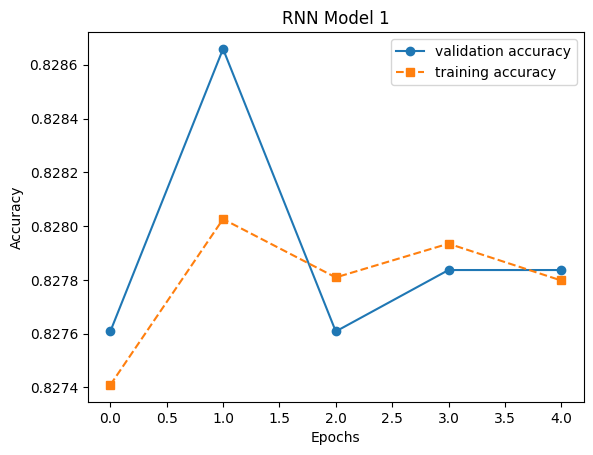

In [ ]:
# Построение кривых обучения
plt.plot(RNN_history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(RNN_history.history['accuracy'], '--s', label='training accuracy')
plt.title('RNN Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 2871.47 секунды (47.5 минут, 5 эпох)  
Точность на тренировочной выборке - 82.80%  
Точность на тестовой выборке - 82.87%

### Анализ работы модели

In [ ]:
# Предсказание вероятностей классов для тестовых данных
y_pred = RNN_model.predict(X_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 100s 145ms/step


In [ ]:
# Конвертация вероятностей в метки классов (предсказанные и истинные)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Confusion matrix:
- Строки представляют истинные метки.
- Столбцы представляют предсказанные метки.
- Диагональные значения указывают на правильную классификацию образцов.
- Недиагональные значения указывают на неправильную классификацию.

In [ ]:
# Формирование confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[18112     0     6     0     0]
 [  544     0    12     0     0]
 [ 1419     0    29     0     0]
 [  162     0     0     0     0]
 [ 1608     0     0     0     0]]


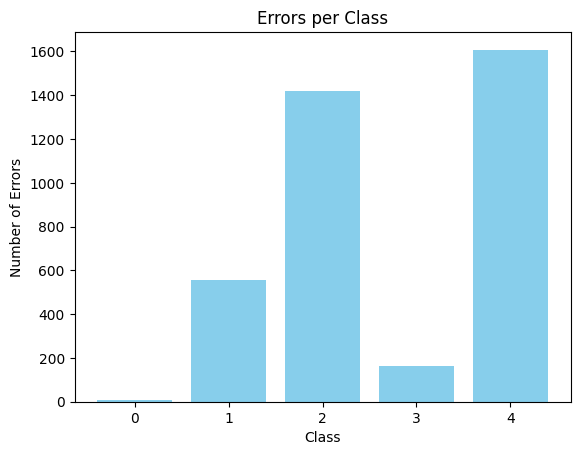

In [ ]:
# Рассчёт ошибок для каждого класса, путём вычитания знаяения на диагонали (правильные прогнозы) из общего числа прогнозов в классе
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)

# Построение гистограммы количества ошибок в классах
plt.bar(range(len(errors_per_class)), errors_per_class, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Errors")
plt.title("Errors per Class")
plt.xticks(range(len(errors_per_class)))
plt.show()

Меньше всего модель допускает ошибок в классе 0.

Модель делает большое количество ошибок во всех остальных классах (особенно в классах 4 и 2).

Высокая точность модели (82.8%) обусловлена тем, что записи класса 0 как раз составляют около 80% датасета.

Это хорошо видно на condusion matrix.

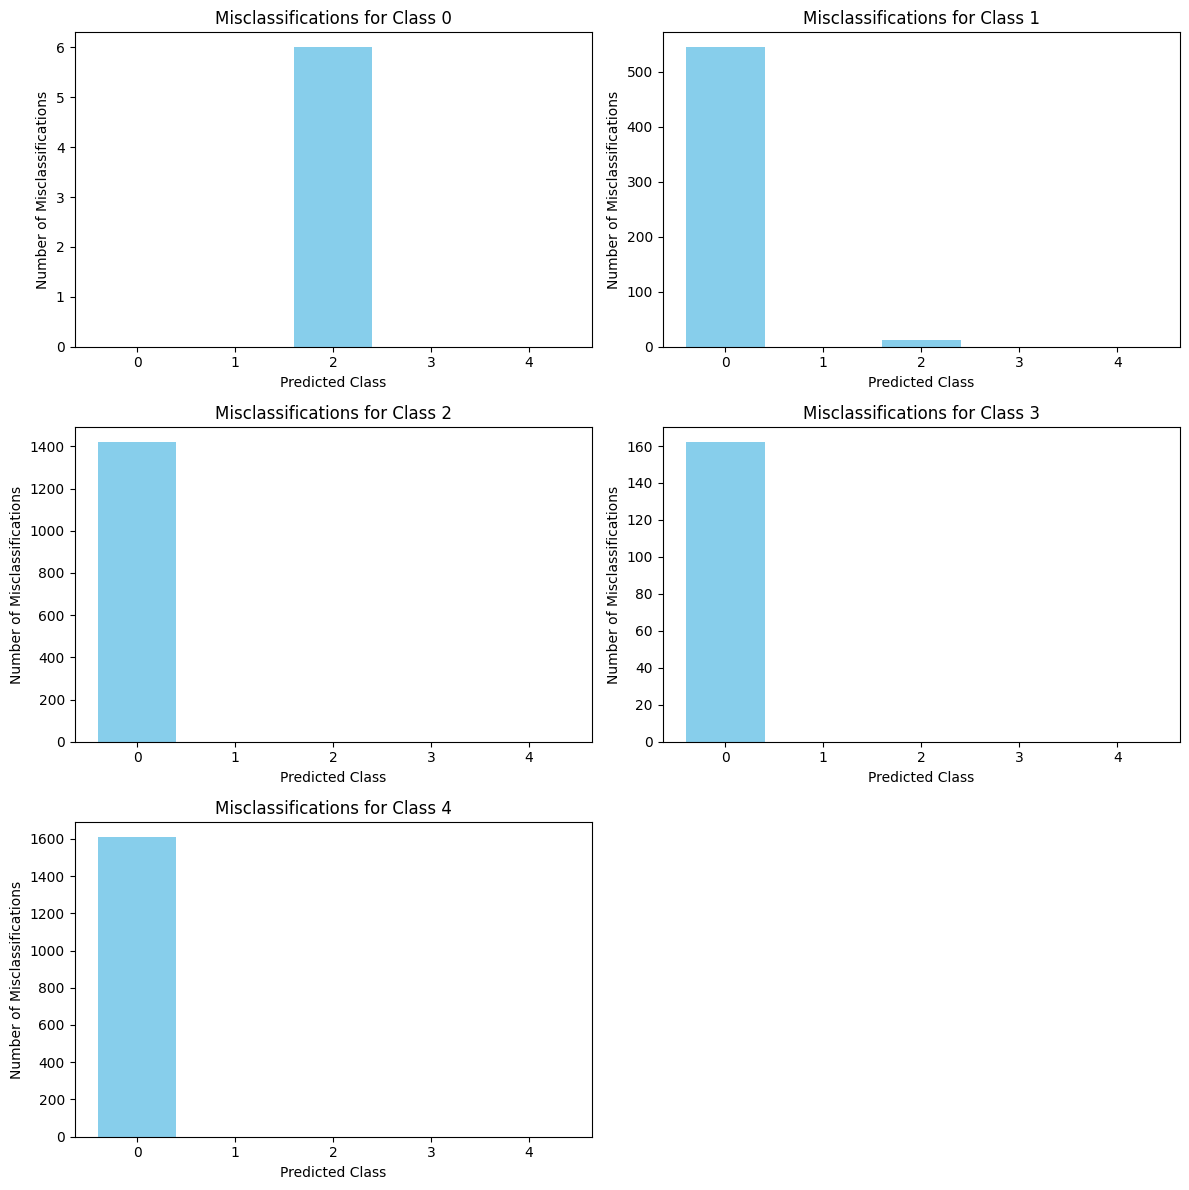

In [ ]:
# Количество классов
num_classes = conf_matrix.shape[0]

# Построение гистограмм для каждого класса, содержащих ложно классифицированные данные по разным классам
# Сетка подграфиков
fig, axes = plt.subplots(nrows=num_classes // 2 + num_classes % 2, ncols=2, figsize=(12, 4 * (num_classes // 2 + num_classes % 2)))
axes = axes.flatten()  # Конвертации сетки в вектор для более удобной итерации по осям

# Построение гистограмм
for i in range(num_classes):
    misclassifications = conf_matrix[i, :].copy()
    misclassifications[i] = 0  # Установка кол-ва правильных ответов = 0 (диагональный элемент), чтобы сосредоточиться только на неправильной классификации

    ax = axes[i]
    ax.bar(range(num_classes), misclassifications, color='skyblue')
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Number of Misclassifications")
    ax.set_title(f"Misclassifications for Class {i}")
    ax.set_xticks(range(num_classes))

# Удаление неиспользуемых подграфиков, если количество классов нечетное
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Информация о классах**

Классы соотносятся как: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

- N: Нормальное сердцебиение
- S: Преждевременное наджелудочковое сердцебиение
- V: Преждевременное сокращение желудочков
- F: Слияние желудочкового и нормального сердцебиения
- Q: Неклассифицируемое сердцебиение

**Таким образом**

1. В редких случаях модель принимает нормальное сердцебиение (класс 0) за Преждевременное сокращение желудочков (класс 2).
2. Объекты, принадлежащие классам 1-4, модель почти всегда классифицируется как класс 0.**То есть модель воспринимает ненормальное сердцебиение как нормальное, что делает её бесполезной.** Более того, модель в принципе почти каждый объект выборки считает классом 0.

In [ ]:
# # Дополнительно: отображение classification report с дополнительными метриками
# print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

## Задача обработки текста

https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data - отзывы клиентов Амазона. В качестве лейблов используйте оценки клиентов.

В задаче обработки текста в качестве входных данных используйте отзывы клиентов, в качестве выходных - их оценки. Получите точность не ниже 90%. Текст необходимо подготовить. Также подготовьте второй датасет, но к нему примените лемматизацию (например, из nltk) текста. При прочих равных параметрах сравните результаты модели, обученной с помощью обычного словаря и с помощью лемматизированного.

### Загрузка и предобработка данных

In [ ]:
# Загрузка датасета
od.download("https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: intergalactik
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products


100%|██████████| 16.3M/16.3M [00:00<00:00, 99.4MB/s]

In [ ]:
# Определение пути к файлу датасета
file_path = './consumer-reviews-of-amazon-products/1429_1.csv'

# Чтение датасета в pd датафрейм
df = pd.read_csv(file_path, low_memory=False)

In [ ]:
# Вывод первых строк датасета
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [ ]:
# Вывод информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [ ]:
# По информации видно, что reviews.rating и reviews.text имеют совсем немного нулевых значений

In [ ]:
# Удаление строк, где 'reviews.text' или 'reviews.rating' имеют нулевые значения
df = df.dropna(subset=['reviews.text', 'reviews.rating'])

# Убеждаемся, что в этих колонках не осталось нулевых значений
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34626 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34626 non-null  object 
 1   name                  27867 non-null  object 
 2   asins                 34624 non-null  object 
 3   brand                 34626 non-null  object 
 4   categories            34626 non-null  object 
 5   keys                  34626 non-null  object 
 6   manufacturer          34626 non-null  object 
 7   reviews.date          34597 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34626 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34626 non-null  float64
 15  reviews.sourceURLs    34

In [ ]:
# Импорт библиотек
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Получение текстов и рейтингов и преобразование их в нужные типы данных
texts = df['reviews.text'].astype(str)
ratings = df['reviews.rating'].astype(int)

In [ ]:
# Убеждаемся, что рейтинг представляет собой 5 классов - оценки от 1 до 5
ratings.unique()

array([5, 4, 2, 1, 3])

In [ ]:
# Функция для предобработки текста
def preprocess_text(text):
    text = text.lower()  # Преобразование в нижний регистр
    text = re.sub(r'[^\w\s]', '', text)  # Удаление знаков пунктуации
    text = re.sub(r'\d+', '', text)  # Удаление чисел
    return text

In [ ]:
"""
Пояснение про удаление чисел

Цифры во многих текстовых наборах данных часто нерелеванты или являются шумом.
Например, номера счетов-фактур, телефонные номера или случайные числовые идентификаторы могут не оказывать существенного влияния на производительность модели.
Их удаление упрощает словарь и снижает ненужную сложность.

Удаление цифр зависит от задачи:
- Нужно удалять цифры, если они вряд ли будут иметь значение в данном контексте.
Пример: В "Я заказал 2 товара, и 1 товар прибыл поврежденным". Конкретные цифры, скорее всего, вносят небольшой вклад в значение фразы.
- Не нужно удалять цифры, если они релеванты в данном контексте.
Пример: "Этот телефон стоит 299,99 долларов, но по ощущениям он стоит 1000 долларов". Здесь цифры важны для контекста.
"""

In [ ]:
# Предобработка текста
texts = texts.apply(preprocess_text)

Далее необходимо выбрать фиксированную длину для текста отзыва.  
Для этого исследуем, сколько обычно слов содержат отзывы в датасете.

Max length: 1806, Average length: 29.93129440304973


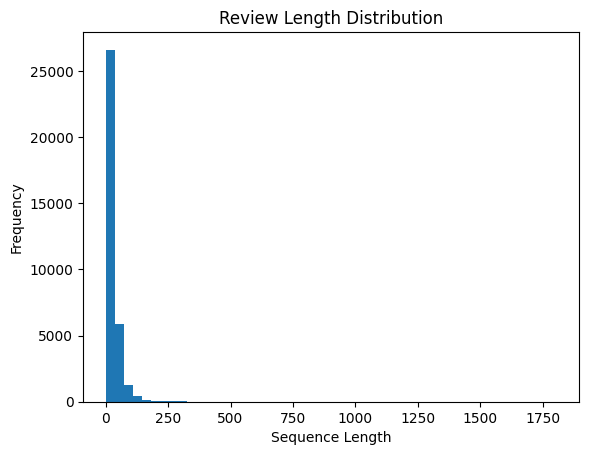

In [ ]:
# Полечение распределения длины отзывов
all_lengths = [len(text.split()) for text in texts]
print(f"Max length: {max(all_lengths)}, Average length: {np.mean(all_lengths)}")

# Построение гистограммы распределения
plt.hist(all_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.show()

Большинство отзывов имеет длину в диапазоне 0-250, построим распределение для этого диапазона.

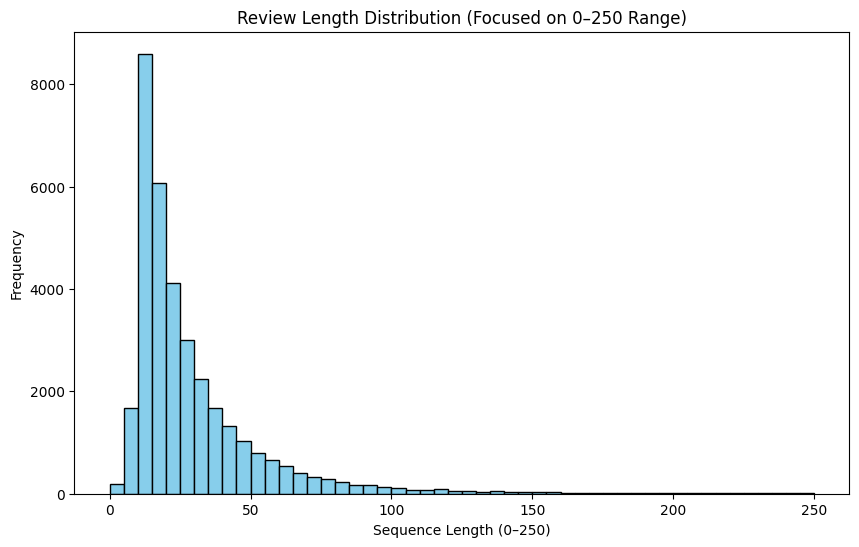

In [ ]:
# Построение распределения длин последовательностей в диапазоне 0-250
plt.figure(figsize=(10, 6))
plt.hist(all_lengths, bins=50, range=(0, 250), color='skyblue', edgecolor='black')
plt.xlabel('Sequence Length (0–250)')
plt.ylabel('Frequency')
plt.title('Review Length Distribution (Focused on 0–250 Range)')
plt.show()

In [ ]:
# Нахождение количетсва и доли отзывов длинной более 250 слов
outliers = sum([1 for length in all_lengths if length > 250])
print(f"Количество отзывов длинной более 250 слов: {outliers}")
print(f"Доля отзывов длинной более 250 слов: {outliers / len(all_lengths):.2%}")

Количество отзывов длинной более 250 слов: 110
Доля отзывов длинной более 250 слов: 0.32%


In [ ]:
# Нахождение количетсва и доли отзывов длинной более 100 слов
outliers = sum([1 for length in all_lengths if length > 100])
print(f"Количество отзывов длинной более 100 слов: {outliers}")
print(f"Доля отзывов длинной более 100 слов: {outliers / len(all_lengths):.2%}")

Количество отзывов длинной более 100 слов: 973
Доля отзывов длинной более 100 слов: 2.81%


In [ ]:
# Нахождение количетсва и доли отзывов длинной более 50 слов
outliers = sum([1 for length in all_lengths if length > 50])
print(f"Количество отзывов длинной более 50 слов: {outliers}")
print(f"Доля отзывов длинной более 50 слов: {outliers / len(all_lengths):.2%}")

Количество отзывов длинной более 50 слов: 4536
Доля отзывов длинной более 50 слов: 13.10%


Таким образом, лучше использовать фиксированную длину текста отзывов - 100 слов, т.к. она охватывает 97% датасета, более длинные отзывы будут урезаться, более мелкие - дополняться до нужной длины.

Доп. информация:
- Лучше не брать длину в 50 слов, т.к. это может ограничить способность модели фиксировать более длинную контекстную информацию в тексте.
- Дополнение отзывов до чрезмерно большой фиксированной длины приводит к потере ресурсов и может привести к переобучению.

In [ ]:
# Токенизация текстов отзывов

max_vocab_size = 10000  # Максимальное количество слов в словаре
max_seq_length = 100    # Максимальная длина текста

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index  # Сопоставление слов с индексами

# Конвератация текстов в последовательности
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [ ]:
"""
Пояснение про max_vocab_size

max_vocab_size - Ограничивает размер словаря до 10 000 наиболее часто встречающихся слов в наборе данных.
Почему именно 10 000?
- Это практическая отправная точка для достижения баланса между размером модели и эффективностью.
- Естественный язык имеет "длинный хвост": небольшое количество слов встречается очень часто,
в то время как многие из них являются редкими. Большинство моделей хорошо работают только с наиболее часто встречающимися словами.
- Редкие слова мало влияют на эффективность модели, но увеличивают вычислительные затраты.
- Для более крупного набора данных или более сложных задач иожно увеличить это число (например, до 20 000 или 50 000).
"""

In [ ]:
# One-hot кодирование отклика
ratings_array = np.array(ratings)
ratings_array = to_categorical(ratings - 1)  # Вычитание 1, чтобы изменить классы на 0-4.

In [ ]:
# Разделение на тестовую и обучающие выборки
X_train2, X_test2, y_train2, y_test2 = train_test_split(padded_sequences, ratings_array, test_size=0.2, random_state=42)

print("Training data shape:", X_train2.shape)
print("Testing data shape:", X_test2.shape)

Training data shape: (27700, 100)
Testing data shape: (6926, 100)


### Построение, обучение и валидация модели

In [ ]:
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM, Dense, Dropout, Input, Embedding, Attention, Flatten
from keras.models import Model
from keras.optimizers import Adam

num_classes = len(np.unique(ratings))  # Количество классов

# Создание модели
# Входной слой
input_layer = Input(shape=(max_seq_length,))

# Слой Embedding
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=128, embeddings_regularizer=l2(0.01))(input_layer)

# Bidirectional LSTM слои
bilstm_output = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.3))(embedding_layer)
bilstm_output = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.3))(bilstm_output)

# Механизм внимания
attention_output = Attention()([bilstm_output, bilstm_output])

# Конвертация в вектор и применение dropout
flattened_output = Flatten()(attention_output)
dropout_layer = Dropout(0.4)(flattened_output)

# Скрытый слой
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer)

# Выходной слой
output_layer = Dense(units=num_classes, activation='softmax')(dense_layer)

# Определение модели
RNN_model2 = Model(inputs=input_layer, outputs=output_layer)

# Компиляция модели
RNN_model2.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Информация о модели
RNN_model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 128)       │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 100, 128)       │         98,816 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 100, 128)       │         98,816 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 100, 128)       │              0 │ bidirectional_3[0][0], │
│                           │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 12800)          │              0 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 12800)          │              0 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │        409,632 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5)              │            165 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,887,429 (7.20 MB)

 Trainable params: 1,887,429 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если val_accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Обучение модели
RNN_history2 = RNN_model2.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping])

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(RNN_history2.history['accuracy']):.4f}")

Epoch 1/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 311s 348ms/step - accuracy: 0.6817 - loss: 2.4159 - val_accuracy: 0.7004 - val_loss: 0.8122
Epoch 2/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 310s 334ms/step - accuracy: 0.7042 - loss: 0.8148 - val_accuracy: 0.7069 - val_loss: 0.7856
Epoch 3/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 321s 333ms/step - accuracy: 0.7109 - loss: 0.7856 - val_accuracy: 0.7075 - val_loss: 0.7912
Epoch 4/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 322s 333ms/step - accuracy: 0.7133 - loss: 0.7798 - val_accuracy: 0.7083 - val_loss: 0.7807
Epoch 5/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 314s 363ms/step - accuracy: 0.7099 - loss: 0.7777 - val_accuracy: 0.7091 - val_loss: 0.7628
Epoch 6/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 303s 340ms/step - accuracy: 0.7155 - loss: 0.7532 - val_accuracy: 0.7098 - val_loss: 0.7663
Epoch 7/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 325s 343ms/step - accuracy: 0.7204 - loss: 0.7471 - val_accuracy: 0.7137 - val_loss: 0.7607
Epoch 8/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 312s 332ms/step - accuracy: 0.7201 -

In [ ]:
# Валидация модели
RNN_model2.evaluate(X_test2, y_test2)

217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.7047 - loss: 0.7733


[0.7606520652770996, 0.713687539100647]

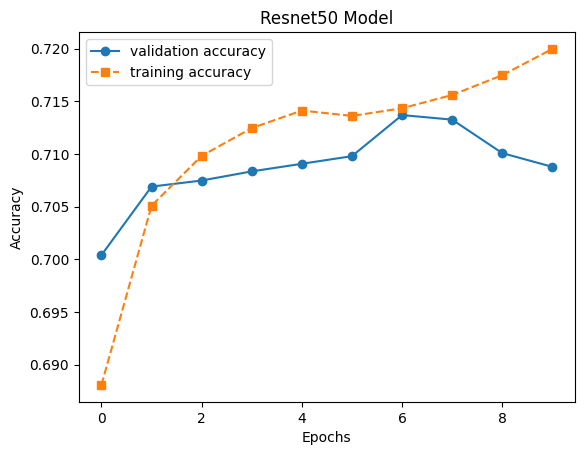

In [ ]:
# Построение кривых обучения
plt.plot(RNN_history2.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(RNN_history2.history['accuracy'], '--s', label='training accuracy')
plt.title('Resnet50 Model') # Опечатка: должно быть "RNN2 Model"
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 3127 секунд (52 минуты, 10 эпох)  
Точность на тренировочной выборке - 72.00%  
Точность на тестовой выборке - 71.37%

Ниже представлены попытки повышения точности. Во всех них модель либо работала хуже полностью, либо скатывалась в переобучение.

### Попытки добиться лучшей точности

#### Использование GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-01-08 19:45:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-08 19:45:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-08 19:45:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Путь к выбранному файлу GloVe
glove_file = 'glove.6B.100d.txt'
embedding_dim = 100

# Загрузка эмбеддингов GloVe в словарь
glove_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} word vectors.")

Loaded 400000 word vectors.


In [ ]:
# Инициализация матрицы эмбеддингов
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

# Заполнение матрицы эмбеддингов
for word, index in tokenizer.word_index.items():
    if index < max_vocab_size:
        embedding_vector = glove_embeddings.get(word)  # Получение вектора GloVe
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector  # Добавление вектора в матрицу

In [ ]:
embedding_layer = Embedding(
    input_dim=max_vocab_size,  # Size of the vocabulary
    output_dim=embedding_dim,  # GloVe vector dimension
    weights=[embedding_matrix],  # Pre-trained GloVe embeddings
    trainable=False  # Freeze embeddings to prevent modification
    # trainable=True
)

#### Уменьшение дисбаланса классов

В данных есть несбалансированность объектов классов (объкты определённых классов сильно превалируют).

In [ ]:
# value_counts - Информация о количестве значений в столбце
df['reviews.rating'].value_counts()

,count
reviews.rating,
5.0,23774
4.0,8541
3.0,1499
1.0,410
2.0,402


In [ ]:
# Установка весов для классов, рассчёт сделан на основе value_counts
class_weights = {
    0: 16.89,  # Для класса 1 (индекс 0)
    1: 17.22,  # Для класса 2 (индекс 1)
    2: 4.62,   # Для класса 3 (индекс 2)
    3: 0.81,   # Для класса 4 (индекс 3)
    4: 0.29    # Для класса 5 (индекс 4)
}

In [ ]:
# Обучение модели
RNN_history2 = RNN_model2.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights)

#### Различные архитектуры

In [ ]:
# Было испробовано много архитектур, всё началось с:
RNN_model2 = Sequential([
    Input(shape=(max_seq_length,)),
    Embedding(input_dim=max_vocab_size, output_dim=128),
    LSTM(units=64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

In [ ]:
RNN_model2 = Sequential([
    Input(shape=(max_seq_length,)),
    Embedding(input_dim=max_vocab_size, output_dim=128),
    # embedding_layer,
    LSTM(units=64, return_sequences=False),
    # LSTM(units=64, return_sequences=True, recurrent_dropout=0.2),
    # LSTM(units=32, return_sequences=False, recurrent_dropout=0.2),
    # Bidirectional(LSTM(units=64, return_sequences=False, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    # Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(units=num_classes, activation='softmax')
])

#### Другие попытки

Изменение емкости словаря и длины текстов, использование stopwords и др.

#### История попыток

1. Изначальная архитектура (указана выше): accuracy = 0.9020;
val_accuracy = 0.6685
2. То же самое, но с GRU вместо LSTM: accuracy = 0.6987; val_accuracy = 0.6805
3. LSTM c регуляризацией: так же как п.2.
```
LSTM(units=64, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)),
```
4. Двойной LSTM с регуляризацией: опять переобучение (п.1).
5. GloVe embeddings: accuracy = 0.7332 , val_accuracy = 0.7140
6. Bidirectional + class weights (уменьшение дисбаланса классов): accuracy = 0.7373; val_accuracy = 0.5749
```
RNN_model2 = Sequential([
    Input(shape=(max_seq_length,)),
    embedding_layer,
    Bidirectional(LSTM(units=64, return_sequences=False, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # Optional dense layer for intermediate representation
    Dense(units=num_classes, activation='softmax')  # Output layer for multiclass classification
])
```
7. Двойной LSTM 150 (взял откуда-то с kaggle): accuracy = 0.6818; val_accuracy = 0.6837
```
RNN_model2 = Sequential([
    Input(shape=(max_seq_length,)),
    Embedding(input_dim=max_vocab_size, output_dim=128),
    LSTM(150, return_sequences=True),
    LSTM(150, return_sequences=False),
    Dense(100, activation='relu', kernel_initializer="uniform"),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # Optional dense layer for intermediate representation
    Dense(units=num_classes, activation='softmax')  # Output layer for multiclass classification
])
```
8. Как п.1 только без Dense 32: accuracy = 0.9100; val_accuracy = 0.6728
9. Изменение размеров + полносвязные слои: accuracy = 0.7344; val_accuracy = 0.6994
```
max_vocab_size = 15000  
max_seq_length = 50     
RNN_model2 = Sequential([
    Input(shape=(max_seq_length,)),  # Explicitly define input shape
    embedding_layer,
    LSTM(units=64, return_sequences=False),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')  # Output layer for multiclass classification
])
```
10. п.1 + stopwords.words('english'): accuracy = 0.8576; val_accuracy = 0.6759
11. Модель с механизмом Внимания (код ниже): accuracy = 0.9219; val_accuracy = 0.6463
Note: at the 2nd epoch it had "0.7277, val_accuracy: 0.7241", but then overfitted.
12. Улучшенная модель с механизмом Внимания (код ниже): accuracy = 0.7164; val_accuracy = 0.7108
13. Модель с механизмом Внимания + stacked bidirectional LSTMs (итоговый вариант в основном блоке): accuracy = 0.7200; val_accuracy = 0.7137

К слову, модель с GloVe чуть лучше итогового варианта.

In [ ]:
# Модель с механизмом Внимания

# Input layer
input_layer = Input(shape=(max_seq_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=128)(input_layer)

# LSTM layer with recurrent dropout
lstm_output = LSTM(units=64, return_sequences=True, recurrent_dropout=0.3)(embedding_layer)

# Attention layer: query = value = lstm_output
attention_output = Attention()([lstm_output, lstm_output])

# Flatten attention output
flattened_output = Flatten()(attention_output)

# Dropout layer for regularization
dropout_layer = Dropout(0.6)(flattened_output)

# Fully connected layer
dense_layer = Dense(units=32, activation='relu', kernel_regularizer=l2(0.001))(dropout_layer)

# Output layer for classification
output_layer = Dense(units=num_classes, activation='softmax')(dense_layer)

# Define the model
model_with_attention = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Улучшенная модель с механизмом Внимания

# Input layer
input_layer = Input(shape=(max_seq_length,))

# Embedding layer with L2 regularization
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=128, embeddings_regularizer=l2(0.01))(input_layer)

# LSTM layer with recurrent dropout
lstm_output = LSTM(units=64, return_sequences=True, recurrent_dropout=0.4)(embedding_layer)

# Attention mechanism: query = value = lstm_output
attention_output = Attention()([lstm_output, lstm_output])

# Flatten attention output
flattened_output = Flatten()(attention_output)

# Dropout layer
dropout_layer = Dropout(0.4)(flattened_output)

# Fully connected layer with L2 regularization
dense_layer = Dense(units=32, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer)

# Output layer for classification
output_layer = Dense(units=num_classes, activation='softmax')(dense_layer)

# Define the model
refined_attention_model = Model(inputs=input_layer, outputs=output_layer)

### Работа модели на лемматизацированных данных

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_with_lemmatization(text):
    # Remove special characters and numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Lemmatize and remove stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Reconstruct the lemmatized text
    return " ".join(lemmatized_tokens)

In [ ]:
# Предобработка текста
texts = texts.apply(preprocess_with_lemmatization)

In [ ]:
# Токенизация текстов отзывов

max_vocab_size = 10000  # Максимальное количество слов в словаре
max_seq_length = 100    # Максимальная длина текста

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index  # Сопоставление слов с индексами

# Конвератация текстов в последовательности
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [ ]:
# Разделение на тестовую и обучающие выборки
X_train2, X_test2, y_train2, y_test2 = train_test_split(padded_sequences, ratings_array, test_size=0.2, random_state=42)

print("Training data shape:", X_train2.shape)
print("Testing data shape:", X_test2.shape)

Training data shape: (27700, 100)
Testing data shape: (6926, 100)


In [ ]:
RNN_model3 = RNN_model2

# Компиляция модели
RNN_model3.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если val_accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Обучение модели
RNN_history3 = RNN_model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping])

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(RNN_history3.history['accuracy']):.4f}")

Epoch 1/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 300s 336ms/step - accuracy: 0.6894 - loss: 0.8385 - val_accuracy: 0.7079 - val_loss: 0.7790
Epoch 2/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 323s 338ms/step - accuracy: 0.7138 - loss: 0.7665 - val_accuracy: 0.7075 - val_loss: 0.7707
Epoch 3/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 295s 341ms/step - accuracy: 0.7121 - loss: 0.7575 - val_accuracy: 0.7040 - val_loss: 0.7681
Epoch 4/20
866/866 ━━━━━━━━━━━━━━━━━━━━ 294s 340ms/step - accuracy: 0.7201 - loss: 0.7524 - val_accuracy: 0.7049 - val_loss: 0.7716
Время обучения: 1213.11 секунды
Лучшая тренировочная точность: 0.7138


In [ ]:
# Валидация модели
RNN_model3.evaluate(X_test2, y_test2)

217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.7006 - loss: 0.7907


[0.779030978679657, 0.7079122066497803]

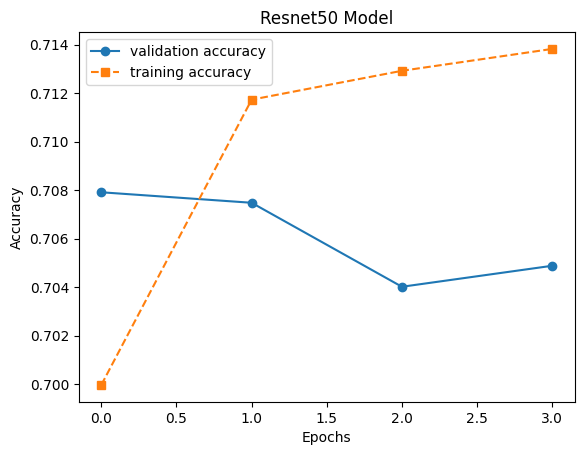

In [ ]:
# Построение кривых обучения
plt.plot(RNN_history3.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(RNN_history3.history['accuracy'], '--s', label='training accuracy')
plt.title('Resnet50 Model') # Опечатка: должно быть "RNN3 Model"
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 1213 секунд (20 минут, 4 эпохи)  
Точность на тренировочной выборке - 71.38%  
Точность на тестовой выборке - 70.79%

Лемматизация данных не улучшила качество модели: модель работает чуть хуже на лемматизированных данных.